# 5-1. 학습 관련 기술들(Techniques) 

- 책 Deep Learning from Scratch 6장 참조할 것

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from collections import OrderedDict
%matplotlib inline

In [2]:
# 이후 테스트를 위한 MNIST 데이터 읽기
# Default로 flatten=True, one_hot_label=False
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

### MultiLayerNet 정의

- 이전엔 TwoLayerNet을 이용했지만, 은닉층의 갯수나 기타 다른 설정들을 유연하게 바꿀 수 있게끔 MultiLayerNet을 정의

In [3]:
# 아래 MultiLayerNet에서 쓰일 함수 정의
# 수치미분
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        it.iternext()   
    return grad

# 아래 두 함수는 SoftmaxWithLoss 계층 클래스에서 쓰임
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 
    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [4]:
# 오차역전파법을 위한 계층 정의
# 아래 MultiLayerNet에서 쓰일 클래스 정의
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        return dx

In [5]:
class MultiLayerNet:
    """완전연결 다층 신경망
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                  self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + \
                                    self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

### 파라미터 최적화 기법

- SGD(Stochastic Gradient Descent)는 parameter 공간에서 지금 위치한 곳에서의 손실함수의 기울기를 계산하여, 가장 빠르게 감소하는 방향으로 이동하는 방법이다.
- 손실함수가 비등방적(anisotropy)일 때, 탐색경로가 비효율적인 단점이 있다.

In [6]:
# SGD의 구현
# 손실함수가 비등방적(anisotropy)일 때, 탐색경로가 비효율적인 단점이 있다.
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    # 별도로 update 메소드를 만드는 것이 좋다.
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

#### Momentum 

- 학습 진행방향으로 모멘텀을 줘서, 학습진행의 급격한 방향 전환을 막는다.
- 따라서 탐색경로가 좀 더 부드러워지며 효율적이게 된다.

In [7]:
# Momentum 기법의 구현
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]

#### AdaGrad 
- 학습을 진행하면서 점차 학습률을 줄여가는 학습률 감소(learning rate decay)를 이용한다.
- 크게 갱신된 매개변수는 학습률이 크게 낮아지게끔 설계하여, 매개변수별로 적응적으로(adaptive) 학습률이 조정된다.

In [8]:
# AdaGrad 기법의 구현
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

#### RMSprop
- AdaGrad의 경우, 학습을 진행할수록 갱신 강도가 약해져서 무한히 계속 학습하면 어느 순간 갱신량이 0이 되어 전혀 학습이 진행되지 않는다.
- RMSprop은 먼 과거의 기울기는 서서히 잊고 최근 기울기 정보를 크게 반영하는 지수이동평균(EMA:Exponential Moving Average)를 이용한다.
- 과거 기울기의 반영 규모를 기하급수적으로 감소시키는 방법으로, AdaGrad의 단점을 보완한다.

In [9]:
# RMSprop 기법의 구현
# AdaGrad의 단점을 보완한 것 (학습률이 0으로 가는 것을 방지)
class RMSprop:
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

####  Adam
- 개략적으로 봤을때, Adam은 Momentum과 AdaGrad를 결합한 방법으로 볼 수 있다.
- 그러나, 이는 정확한 설명은 아니므로 아래의 논문 참조할 것
- http://arxiv.org/abs/1412.6980v8
- 편향 보정이 진행된다는 점이 특징이다.

In [10]:
# Adam 기법의 구현
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1   # 1차 모멘텀용 계수
        self.beta2 = beta2   # 2차 모멘텀용 계수
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        # self.iter 가 증가할수록 lr_t는 감소한다. (처음엔 급하게, 나중엔 완만하게 감소)
        # 따라서 이 부분은 AdaGrad처럼 학습률 감소를 의미한다.
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            # 아래 식을 전개해보면, Momentum, AdaGrad와 유사한 부분들을 찾을 수 있다.
            # 그러나 Adam을 단순히 Momentum과 AdaGrad가 결합된 방식으로만 이해하지는 말 것!
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            # unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            # unbias_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            # params[key] += self.lr * unbias_m / (np.sqrt(unbias_b) + 1e-7)

#### MNIST 데이터에 대하여 optimizer 비교
- AdaGrad > Adam > RMSprop > Momentum > SGD 순으로 좋아보이지만, 학습률이나 층 깊이 등의 하이퍼파라미터에 따라 결과는 달라질 수 있다.

===========iteration:1===========
SGD:2.4133158770424306
Momentum:2.413215927981608
AdaGrad:2.068177682302992
Adam:2.216667354006495
RMSprop:13.347797943762357
===========iteration:1000===========
SGD:0.29433030088508977
Momentum:0.0777413407570405
AdaGrad:0.016849850794869267
Adam:0.02851185934097599
RMSprop:0.4873199554723575
===========iteration:2000===========
SGD:0.18727523887810948
Momentum:0.045884700004626945
AdaGrad:0.023464508125118258
Adam:0.03326250800426563
RMSprop:0.1342348027860261


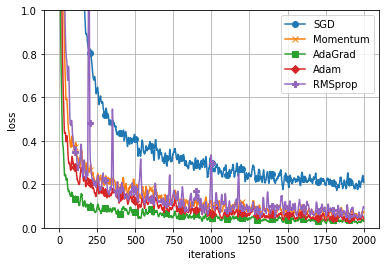

In [11]:
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(input_size=784,
                                hidden_size_list=[100, 100, 100, 100],
                                output_size=10)
    train_loss[key] = []    

for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i == 0 or (i+1) % 1000 == 0:
        print( "===========" + "iteration:" + str(i+1) + "===========")
        for key in optimizers.keys():
            loss = train_loss[key][-1]
            print(key + ":" + str(loss))

# 그래프 그리기
def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용
    
    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D", "RMSprop": "P"}
x = np.arange(1, max_iterations+1)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.show()

### 가중치의 초깃값

- 가중치가 전부 균일한 값으로 설정되면 학습을 거쳐도 여전히 서로 같은 값을 유지하고 있어 가중치를 여러개 갖는 의미를 사라지게 한다.
- 따라서 가중치의 대칭적인 구조를 무너뜨리도록 초깃값을 무작위로 설정해야 한다.

In [12]:
# 은닉층(hidden layers)의 활성화값의 분포를 관찰하면서 초깃값의 영향을 확인한다.
# 다양한 활성화함수에 대해 테스트하기 위해 아래와같이 정의한다.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

# 히스토그램 그려주는 함수
def draw_histogram(activations, ylim):
    plt.figure(figsize=(15,4))
    for i, a in activations.items():
        plt.subplot(1, len(activations), i+1)
        plt.title(str(i+1) + "-layer")
        if i != 0: plt.yticks([], [])
        plt.xlim(0, 1)
        plt.ylim(0, ylim)
        plt.hist(a.flatten(), 30, range=(0,1))
    plt.show()

node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개 (즉, 6층 신경망을 구성하여 테스트)
activations = {}  # 이곳에 활성화 결과를 저장

####  표준정규분포로 초기화
- 활성화값들이 0과 1로 치우쳐져 있다. 이는 대부분의 정의역에 대해 0과 1에 가까운 수를 출력하는 Sigmoid 함수의 특징 때문이다.
- 역전파 시 기울기 값이 층을 거듭할수록 작아지다가 사라지게 되는데, 이를 기울기 소실(gradient vanishing) 문제라고 한다.
- 층을 깊게 하는 딥러닝에서 이는 심각한 문제가 될 수 있다.

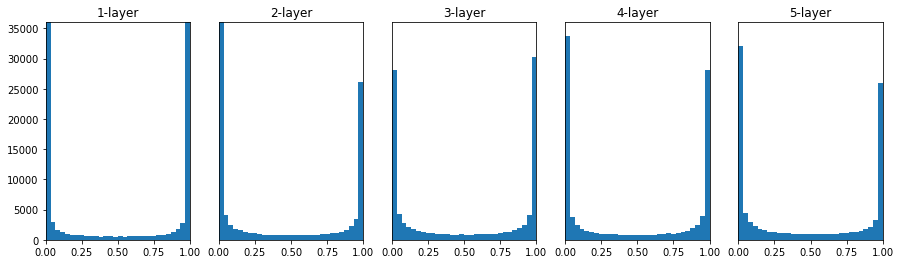

In [13]:
x = np.random.randn(1000, 100)  # 1000개의 데이터

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 표준정규분포로 한다.
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

draw_histogram(activations, 36000)

####  정규분포의 표준편차 조정
- 아무값이 0.01로 표준편차를 조정하니, 0.5 부근에 활성화값들이 극단적으로 치우친다.
- 다수의 뉴런이 거의 같은 값을 출력하고 있으니 뉴런을 여러 개 둔 의미가 없어진다는 뜻으로, 표현력이 제한된다는 문제가 있다.

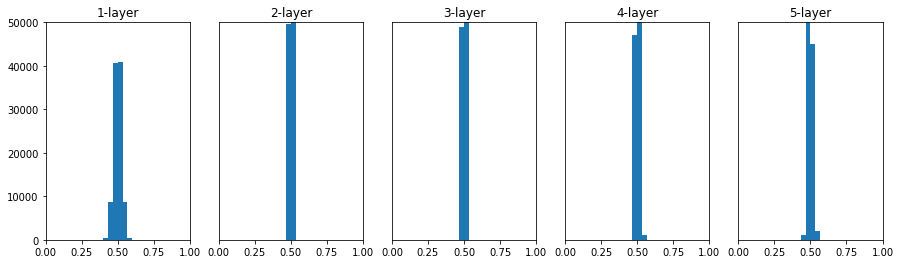

In [14]:
x = np.random.randn(1000, 100)  # 1000개의 데이터

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 정규분포의 표준편차를 조정한다.
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

draw_histogram(activations, 50000)

#### Xavier 초깃값
- 활성화함수가 선형인 것을 전제로 한다. (Sigmoid나 tanh는 원점부근에서 선형으로 근사되므로 적용가능)
- Xavier 초깃값이란 바로 앞 계층의 노드 갯수의 역수의 제곱근을 표준편차로 하는 정규분포를 이용하여 매개변수들을 초기화한 값이다.
- 사실, Xavier Glorot & Yoshua Bengio 논문에서는 앞 층의 노드 수 뿐 아니라 다음 층의 노드 수도 고려한 설정값을 제안한다.
- Xavier Glorot & Yoshua Bengio 논문 참조 http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

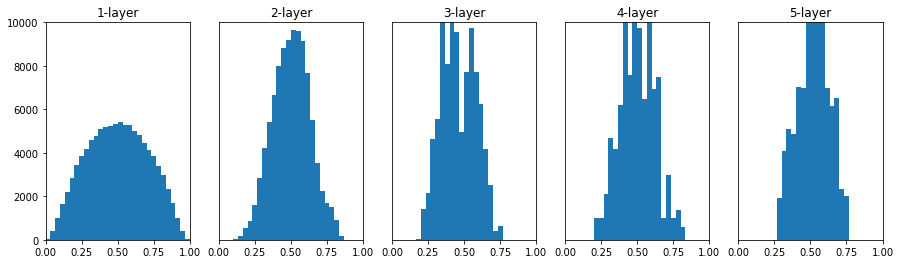

In [15]:
x = np.random.randn(1000, 100)  # 1000개의 데이터

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # Xavier 초깃값 이용
    # 바로 직전 층 노드 갯수의 역수의 제곱근을 표준정규분포의 표준편차에 곱해준다.
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

draw_histogram(activations, 10000)

#### 활성화함수로서의 tanh 함수
- 위의 결과는 모든 층에서 비교적 고른 분포를 보이지만, 그래도 층이 깊어질수록 형태가 일그러진다.
- 활성화함수는 원점에서 대칭인 함수가 바람직하다고 알려져 있는데, 이에 따라 tanh 함수를 이용하면 형태의 일그러짐을 완화할 수 있다.
- 아래 결과를 보면, 0~1 사이의 전범위에 활성화값이 분포되어 있음을 알 수 있다.
- 그러나 여기서도 극단적이진 않지만, 층이 깊어지면 0쪽으로 치우쳐가는 모습이 보이긴 한다.

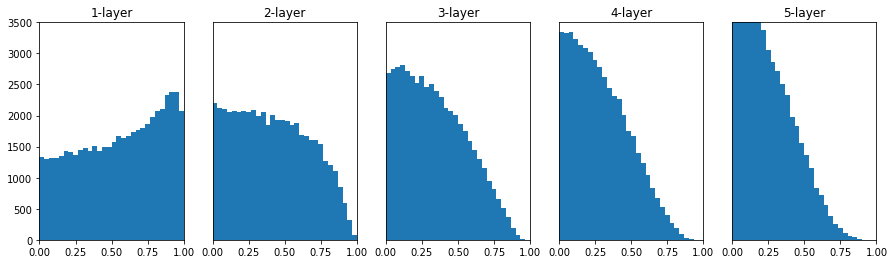

In [16]:
x = np.random.randn(1000, 100)  # 1000개의 데이터

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # Xavier 초깃값
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    a = np.dot(x, w)
    # 활성화함수는 원점에서 대칭인 함수가 바람직하다고 알려져 있는데,
    # 이에 따라 tanh 함수를 이용하면 형태의 일그러짐을 완화할 수 있다.
    z = tanh(a)
    activations[i] = z

draw_histogram(activations, 3500)

#### He 초깃값
- 최근 Sigmoid보다 더 자주 이용되는 ReLU의 경우, He 초깃값이 권장된다. (Kaiming He 발견)
- 앞 계층의 노드 갯수의 역수를 2배 한 후 제곱근을 취한 값을 표준편차로 하는 정규분포를 이용하여 매개변수들을 초기화한다.

=============== TEST CASE : 표준편차 0.01 ===============


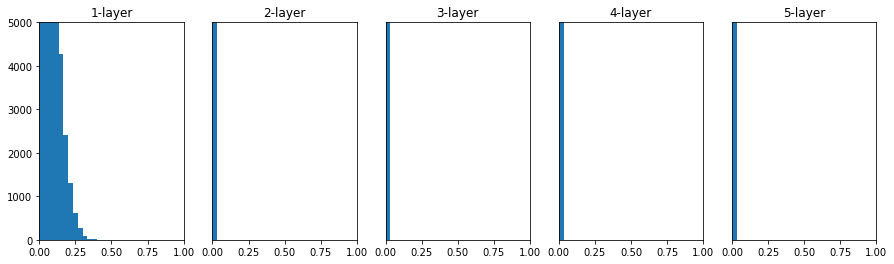

=============== TEST CASE : Xavier ===============


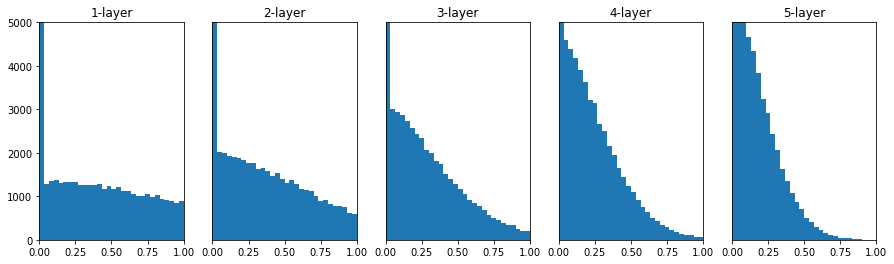

=============== TEST CASE : He ===============


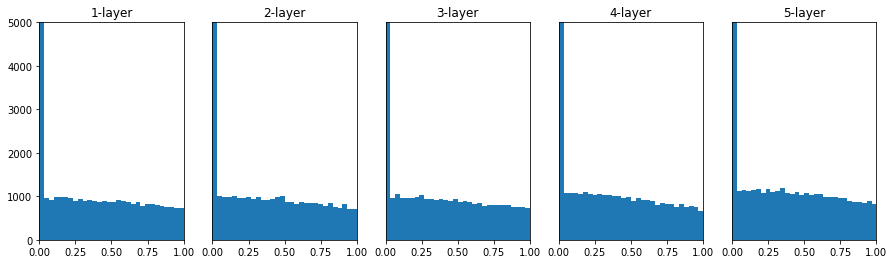

In [17]:
cases = ["표준편차 0.01", "Xavier", "He"]
for idx, init_factor in enumerate([0.01, np.sqrt(1.0 / node_num), np.sqrt(2.0 / node_num)]):
    x = np.random.randn(1000, 100)  # 1000개의 데이터
    for i in range(hidden_layer_size):
        if i != 0:
            x = activations[i-1]
    
        w = np.random.randn(node_num, node_num) * init_factor
        a = np.dot(x, w)
        # 활성화 함수가 ReLU인 경우
        z = ReLU(a)
        activations[i] = z
    print("="*15, "TEST CASE :", cases[idx], "="*15)
    draw_histogram(activations, 5000)

- 위 결과를 보면, 0.01 표준편차에서는 전반적으로 활성화값이 매우 작아 역전파 때 가중치의 기울기 역시 작아지는 문제가 발생한다.
- Xaiver 초깃값 역시 층이 깊어지면 0으로 치우치게 되어 기울기 소실 문제가 발생한다.

#### MNIST 데이터에 대하여 다양한 초깃값 비교

===========iteration:1===========
std=0.01:2.3024271867151356
Xavier:2.291433075726167
He:2.277162536763911
===========iteration:500===========
std=0.01:2.302322319312684
Xavier:0.9372745038177871
He:0.49703672074095606
===========iteration:1000===========
std=0.01:2.304598395116682
Xavier:0.41445041182854403
He:0.27999652622744264
===========iteration:1500===========
std=0.01:2.296360175665045
Xavier:0.3782866499319975
He:0.1969435582704917
===========iteration:2000===========
std=0.01:2.2943036211025287
Xavier:0.3097785837972401
He:0.19261517268941108


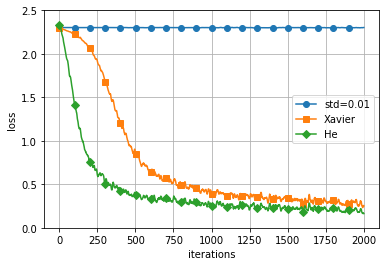

In [18]:
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i == 0 or (i+1) % 500 == 0:
        print("===========" + "iteration:" + str(i+1) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(1, max_iterations+1)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.grid()
plt.legend()
plt.show()